## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

### Checks

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)


%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


In [6]:
solvers_reconstruct = at3d.containers.SolversDict()

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)
def get_loss(reff_diff):
    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.408E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.295  0.454E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.656  0.476E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.909  0.292E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.262  0.162E+00    32911   103.62  0.405   [Radiance 0.660 micron]
     6  -2.283  0.881E-01    35975   115.52  0.451   [Radiance 0.660 micron]
     7  -2.355  0.637E-01    39801   127.75  0.499   [Radiance 0.660 micron]
     8  -2.458  0.508E-01    43920   138.71  0.542   [Radiance 0.660 micron]
     9  -2.539  0.414E-01    48905   149.50  0.584   [Radiance 0.660 micron]
    10  -2.604  0.347E-01    54597   159.64  0.624   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    60438   168.15  0.657   [Radiance 0.660 micron]
    12  -3.007  0.300E-01    60650   168.33  0.658   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

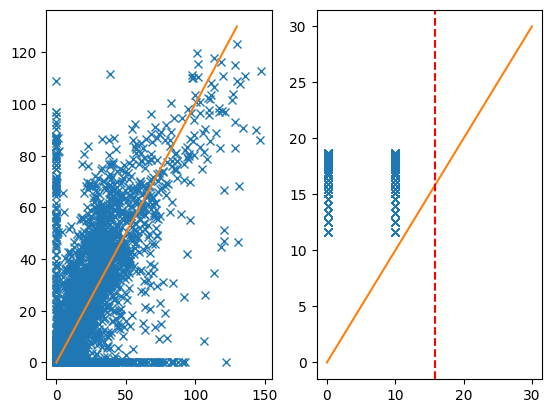

10521.908677424017
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.725  0.406E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.294  0.452E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.657  0.474E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.912  0.293E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.268  0.161E+00    32889   103.53  0.404   [Radiance 0.660 micron]
     6  -2.283  0.873E-01    35974   115.52  0.451   [Radiance 0.660 micron]
     7  -2.357  0.633E-01    39698   127.50  0.498   [Radiance 0.660 micron]
     8  -2.458  0.505E-01    43758   138.29  0.540   [Radiance 0.660 micron]
     9  -2.542  0.412E-01    48645   148.98  0.582   [Radiance 0.660 micron]
    10  -2.614  0.346E-01    54240   159.07  0.621   [Radiance 0.660 micron]
    11  -2.720  0.300E-01    59905   167.50  0.654   [Radiance 0.660 micron]
    12  -3.002  0.300E-01    60122   167.70  0.655   [Radian

<Figure size 640x480 with 0 Axes>

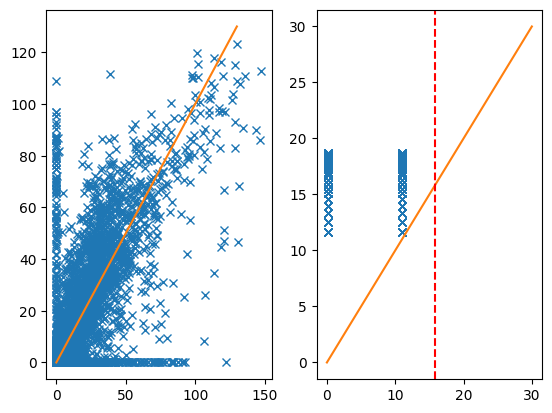

8724.284228896055
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.724  0.404E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.294  0.450E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.658  0.471E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.914  0.290E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.272  0.160E+00    32879   103.48  0.404   [Radiance 0.660 micron]
     6  -2.285  0.868E-01    35946   115.42  0.451   [Radiance 0.660 micron]
     7  -2.358  0.630E-01    39641   127.34  0.497   [Radiance 0.660 micron]
     8  -2.460  0.504E-01    43575   137.85  0.538   [Radiance 0.660 micron]
     9  -2.539  0.411E-01    48477   148.66  0.581   [Radiance 0.660 micron]
    10  -2.623  0.346E-01    53844   158.40  0.619   [Radiance 0.660 micron]
    11  -2.715  0.300E-01    59447   166.88  0.652   [Radiance 0.660 micron]
    12  -3.004  0.300E-01    59672   167.11  0.653   [Radianc

<Figure size 640x480 with 0 Axes>

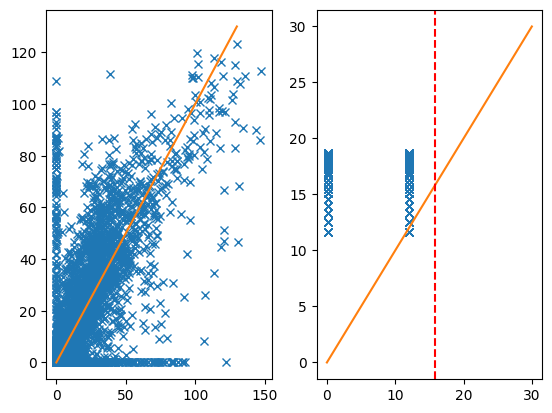

7407.414722868481
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.724  0.402E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.293  0.448E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.659  0.469E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.915  0.289E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.274  0.160E+00    32875   103.46  0.404   [Radiance 0.660 micron]
     6  -2.287  0.864E-01    35903   115.30  0.450   [Radiance 0.660 micron]
     7  -2.362  0.627E-01    39561   127.12  0.497   [Radiance 0.660 micron]
     8  -2.458  0.501E-01    43521   137.71  0.538   [Radiance 0.660 micron]
     9  -2.543  0.410E-01    48254   148.24  0.579   [Radiance 0.660 micron]
    10  -2.621  0.345E-01    53652   158.10  0.618   [Radiance 0.660 micron]
    11  -2.715  0.300E-01    59025   166.30  0.650   [Radiance 0.660 micron]
    12  -3.003  0.300E-01    59234   166.52  0.650   [Radianc

<Figure size 640x480 with 0 Axes>

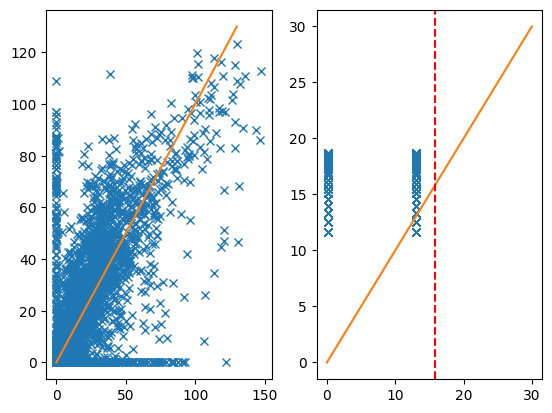

6420.865456263675
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.723  0.401E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.293  0.446E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.660  0.468E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.917  0.289E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.277  0.159E+00    32865   103.42  0.404   [Radiance 0.660 micron]
     6  -2.289  0.860E-01    35885   115.25  0.450   [Radiance 0.660 micron]
     7  -2.364  0.625E-01    39488   126.92  0.496   [Radiance 0.660 micron]
     8  -2.457  0.498E-01    43447   137.55  0.537   [Radiance 0.660 micron]
     9  -2.542  0.410E-01    48091   147.89  0.578   [Radiance 0.660 micron]
    10  -2.625  0.345E-01    53385   157.66  0.616   [Radiance 0.660 micron]
    11  -2.717  0.300E-01    58651   165.78  0.648   [Radiance 0.660 micron]
    12  -3.013  0.300E-01    58857   166.02  0.649   [Radianc

<Figure size 640x480 with 0 Axes>

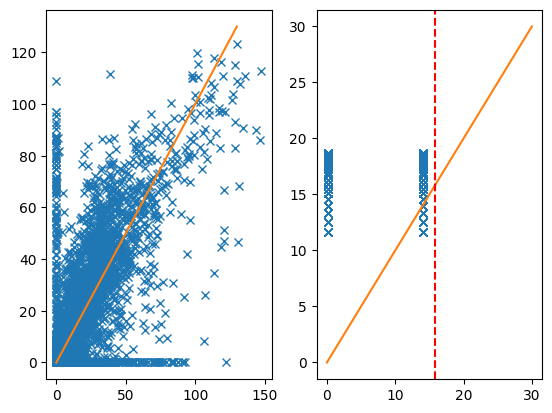

5682.296225157306
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.723  0.400E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.292  0.445E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.661  0.466E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.918  0.288E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.278  0.159E+00    32863   103.41  0.404   [Radiance 0.660 micron]
     6  -2.290  0.857E-01    35862   115.16  0.450   [Radiance 0.660 micron]
     7  -2.365  0.623E-01    39412   126.68  0.495   [Radiance 0.660 micron]
     8  -2.460  0.497E-01    43343   137.29  0.536   [Radiance 0.660 micron]
     9  -2.543  0.408E-01    47993   147.70  0.577   [Radiance 0.660 micron]
    10  -2.625  0.344E-01    53186   157.32  0.615   [Radiance 0.660 micron]
    11  -2.720  0.300E-01    58323   165.32  0.646   [Radiance 0.660 micron]
    12  -3.015  0.300E-01    58503   165.52  0.647   [Radianc

<Figure size 640x480 with 0 Axes>

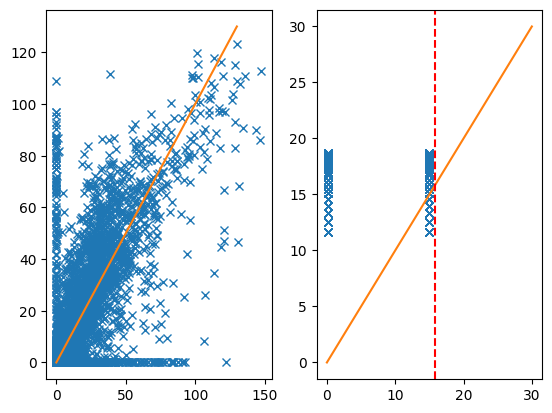

5136.228088956824
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.722  0.398E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.292  0.444E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.661  0.465E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.919  0.288E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.281  0.158E+00    32856   103.38  0.404   [Radiance 0.660 micron]
     6  -2.290  0.854E-01    35856   115.15  0.450   [Radiance 0.660 micron]
     7  -2.367  0.622E-01    39342   126.49  0.494   [Radiance 0.660 micron]
     8  -2.460  0.496E-01    43239   137.05  0.535   [Radiance 0.660 micron]
     9  -2.544  0.408E-01    47886   147.52  0.576   [Radiance 0.660 micron]
    10  -2.625  0.343E-01    53044   157.08  0.614   [Radiance 0.660 micron]
    11  -2.721  0.300E-01    58066   164.98  0.644   [Radiance 0.660 micron]
    12  -3.015  0.300E-01    58254   165.18  0.645   [Radianc

<Figure size 640x480 with 0 Axes>

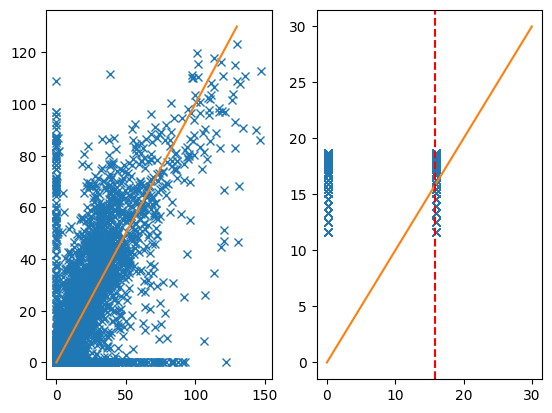

4723.93410945889
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.722  0.397E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.292  0.443E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.662  0.463E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.920  0.287E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.284  0.158E+00    32841   103.33  0.404   [Radiance 0.660 micron]
     6  -2.289  0.851E-01    35833   115.07  0.449   [Radiance 0.660 micron]
     7  -2.368  0.621E-01    39300   126.36  0.494   [Radiance 0.660 micron]
     8  -2.459  0.495E-01    43146   136.79  0.534   [Radiance 0.660 micron]
     9  -2.545  0.408E-01    47724   147.18  0.575   [Radiance 0.660 micron]
    10  -2.624  0.343E-01    52864   156.75  0.612   [Radiance 0.660 micron]
    11  -2.722  0.300E-01    57851   164.71  0.643   [Radiance 0.660 micron]
    12  -3.016  0.300E-01    58035   164.90  0.644   [Radiance

<Figure size 640x480 with 0 Axes>

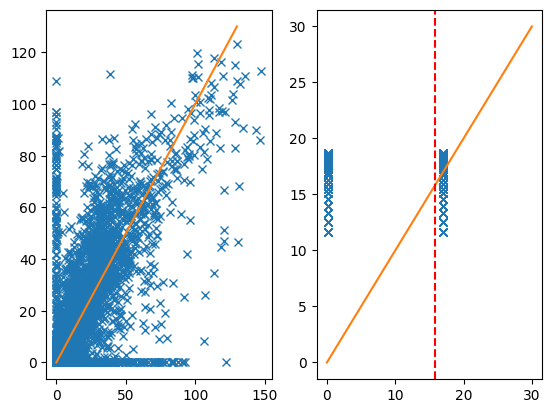

4414.461925411059
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.397E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.442E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.662  0.462E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.921  0.287E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.285  0.157E+00    32840   103.32  0.404   [Radiance 0.660 micron]
     6  -2.290  0.849E-01    35818   115.02  0.449   [Radiance 0.660 micron]
     7  -2.368  0.620E-01    39244   126.19  0.493   [Radiance 0.660 micron]
     8  -2.462  0.494E-01    43101   136.71  0.534   [Radiance 0.660 micron]
     9  -2.546  0.407E-01    47628   147.02  0.574   [Radiance 0.660 micron]
    10  -2.625  0.342E-01    52755   156.60  0.612   [Radiance 0.660 micron]
    11  -2.722  0.300E-01    57630   164.41  0.642   [Radiance 0.660 micron]
    12  -3.024  0.300E-01    57801   164.57  0.643   [Radianc

<Figure size 640x480 with 0 Axes>

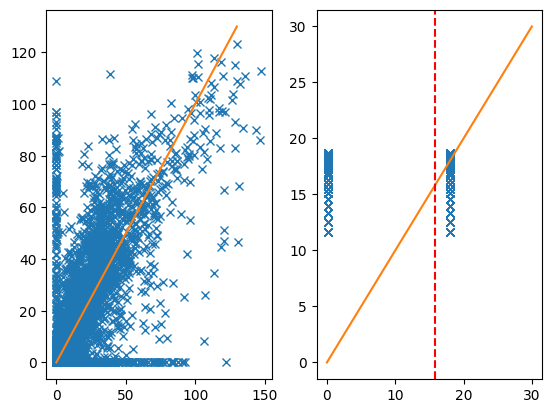

4191.272263902254
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.396E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.441E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.662  0.461E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.922  0.286E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.286  0.158E+00    32835   103.30  0.404   [Radiance 0.660 micron]
     6  -2.290  0.847E-01    35808   114.99  0.449   [Radiance 0.660 micron]
     7  -2.369  0.619E-01    39216   126.10  0.493   [Radiance 0.660 micron]
     8  -2.463  0.493E-01    43046   136.56  0.533   [Radiance 0.660 micron]
     9  -2.545  0.406E-01    47583   146.93  0.574   [Radiance 0.660 micron]
    10  -2.627  0.342E-01    52600   156.32  0.611   [Radiance 0.660 micron]
    11  -2.723  0.300E-01    57408   164.08  0.641   [Radiance 0.660 micron]
    12  -3.024  0.300E-01    57585   164.25  0.642   [Radianc

<Figure size 640x480 with 0 Axes>

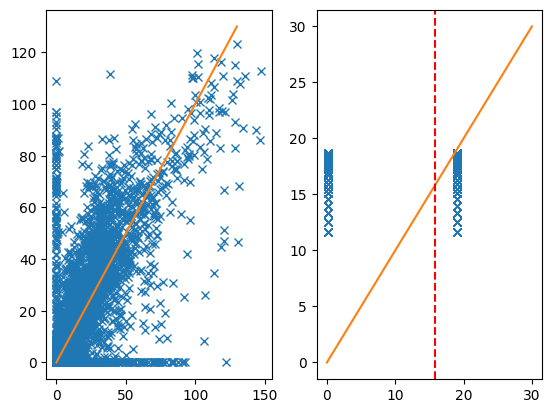

4020.5538027736557
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.395E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.440E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.460E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.922  0.286E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.287  0.157E+00    32831   103.29  0.403   [Radiance 0.660 micron]
     6  -2.291  0.846E-01    35790   114.93  0.449   [Radiance 0.660 micron]
     7  -2.370  0.618E-01    39201   126.06  0.492   [Radiance 0.660 micron]
     8  -2.463  0.493E-01    43006   136.47  0.533   [Radiance 0.660 micron]
     9  -2.547  0.405E-01    47497   146.77  0.573   [Radiance 0.660 micron]
    10  -2.625  0.341E-01    52528   156.19  0.610   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    57222   163.79  0.640   [Radiance 0.660 micron]
    12  -3.028  0.300E-01    57397   163.99  0.641   [Radian

<Figure size 640x480 with 0 Axes>

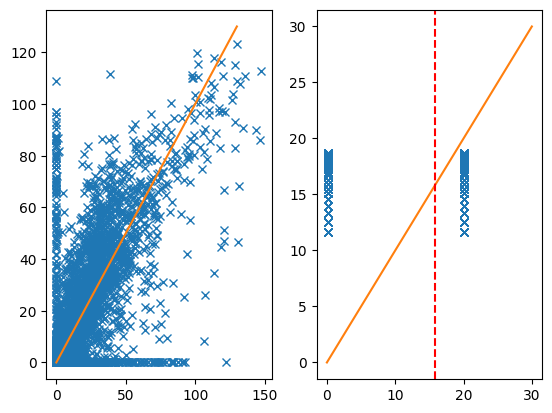

3900.539245050456
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.394E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.439E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.460E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.923  0.285E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.288  0.157E+00    32824   103.26  0.403   [Radiance 0.660 micron]
     6  -2.291  0.844E-01    35776   114.87  0.449   [Radiance 0.660 micron]
     7  -2.369  0.617E-01    39182   125.99  0.492   [Radiance 0.660 micron]
     8  -2.465  0.493E-01    42959   136.37  0.533   [Radiance 0.660 micron]
     9  -2.548  0.405E-01    47438   146.63  0.573   [Radiance 0.660 micron]
    10  -2.626  0.341E-01    52482   156.11  0.610   [Radiance 0.660 micron]
    11  -2.733  0.300E-01    57086   163.61  0.639   [Radiance 0.660 micron]
    12  -3.029  0.300E-01    57264   163.82  0.640   [Radianc

<Figure size 640x480 with 0 Axes>

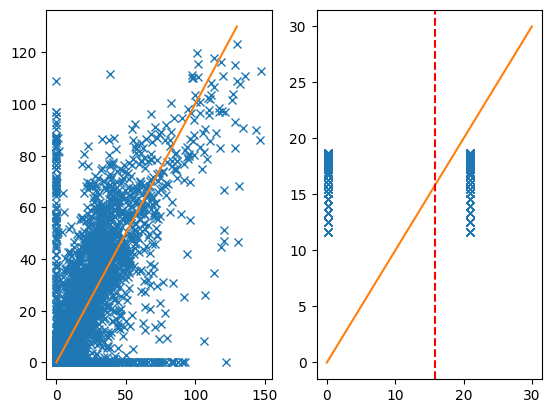

3819.7183233132337
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.394E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.439E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.459E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.923  0.285E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.289  0.157E+00    32821   103.25  0.403   [Radiance 0.660 micron]
     6  -2.292  0.843E-01    35760   114.82  0.449   [Radiance 0.660 micron]
     7  -2.370  0.616E-01    39164   125.95  0.492   [Radiance 0.660 micron]
     8  -2.466  0.492E-01    42922   136.28  0.532   [Radiance 0.660 micron]
     9  -2.548  0.404E-01    47407   146.60  0.573   [Radiance 0.660 micron]
    10  -2.627  0.341E-01    52373   155.93  0.609   [Radiance 0.660 micron]
    11  -2.734  0.300E-01    56949   163.42  0.638   [Radiance 0.660 micron]
    12  -3.029  0.300E-01    57121   163.60  0.639   [Radian

<Figure size 640x480 with 0 Axes>

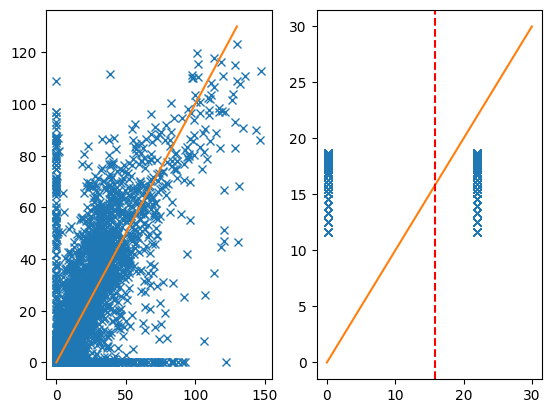

3767.5653219547344
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.393E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.438E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.458E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.924  0.285E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.290  0.156E+00    32817   103.23  0.403   [Radiance 0.660 micron]
     6  -2.292  0.841E-01    35758   114.81  0.448   [Radiance 0.660 micron]
     7  -2.369  0.615E-01    39155   125.92  0.492   [Radiance 0.660 micron]
     8  -2.467  0.492E-01    42866   136.14  0.532   [Radiance 0.660 micron]
     9  -2.548  0.403E-01    47378   146.53  0.572   [Radiance 0.660 micron]
    10  -2.628  0.340E-01    52293   155.81  0.609   [Radiance 0.660 micron]
    11  -2.737  0.300E-01    56817   163.22  0.638   [Radiance 0.660 micron]
    12  -3.026  0.300E-01    56977   163.37  0.638   [Radian

<Figure size 640x480 with 0 Axes>

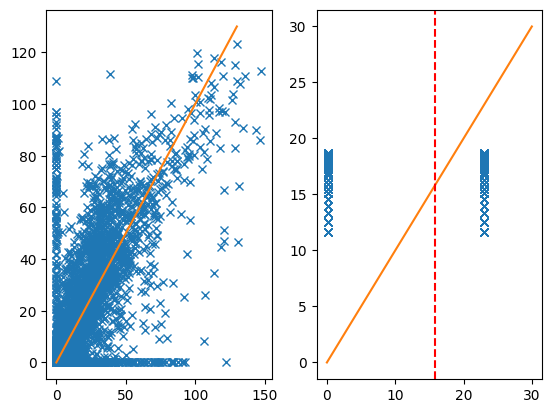

3737.741771192191
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.393E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.437E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.457E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.924  0.280E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.288  0.156E+00    32817   103.23  0.403   [Radiance 0.660 micron]
     6  -2.294  0.843E-01    35723   114.68  0.448   [Radiance 0.660 micron]
     7  -2.369  0.615E-01    39129   125.87  0.492   [Radiance 0.660 micron]
     8  -2.468  0.492E-01    42817   136.01  0.531   [Radiance 0.660 micron]
     9  -2.546  0.403E-01    47347   146.46  0.572   [Radiance 0.660 micron]
    10  -2.630  0.341E-01    52164   155.59  0.608   [Radiance 0.660 micron]
    11  -2.738  0.300E-01    56686   163.04  0.637   [Radiance 0.660 micron]
    12  -3.023  0.300E-01    56866   163.22  0.638   [Radianc

<Figure size 640x480 with 0 Axes>

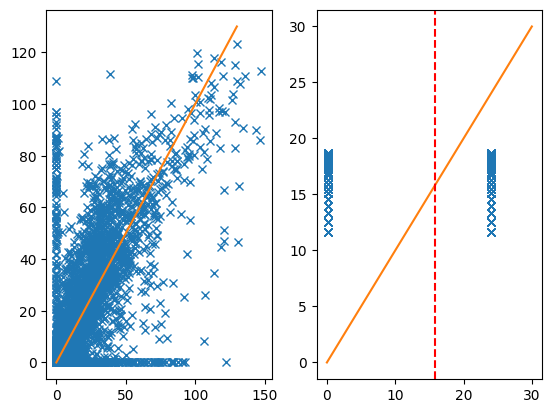

3725.2976820917056


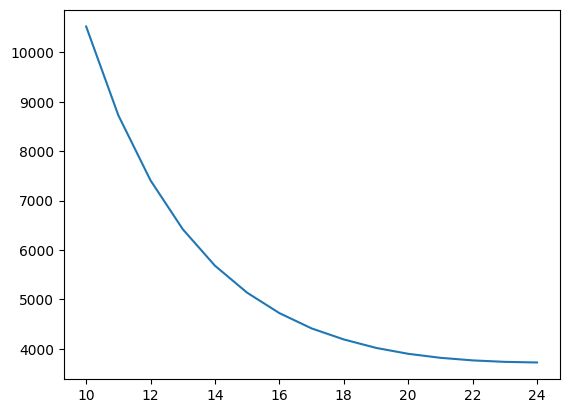

In [22]:
#after back and forth retrieval with 10 and 25 reff. Last was 25
losses = []
for i in range(10, 25):
    solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers_reconstruct[0.66].medium['cloud'].reff.data * 0 + i
    initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers_reconstruct[0.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    loss = objective_function(x0)[0]
    plot(None)
    print(loss)
    losses.append(loss)
py.plot(range(10, 25), losses)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.392E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.437E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.457E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.924  0.279E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.288  0.156E+00    32810   103.21  0.403   [Radiance 0.660 micron]
     6  -2.295  0.841E-01    35716   114.65  0.448   [Radiance 0.660 micron]
     7  -2.370  0.614E-01    39119   125.84  0.492   [Radiance 0.660 micron]
     8  -2.468  0.491E-01    42793   135.94  0.531   [Radiance 0.660 micron]
     9  -2.547  0.403E-01    47289   146.35  0.572   [Radiance 0.660 micron]
    10  -2.629  0.340E-01    52141   155.56  0.608   [Radiance 0.660 micron]
    11  -2.739  0.300E-01    56553   162.82  0.636   [Radiance 0.660 micron]
    12  -3.025  0.300E-01    56733   163.00  0.637   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

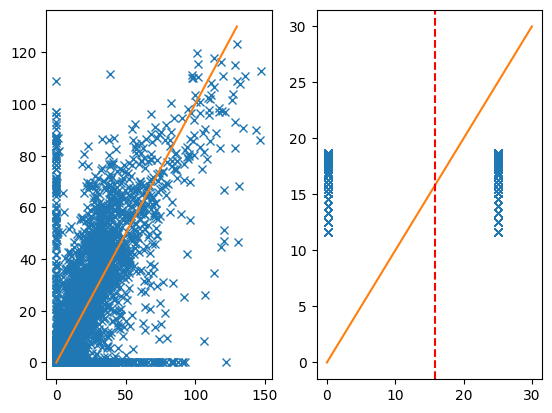

3730.1156937858705
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.392E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.436E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.456E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.925  0.279E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.289  0.156E+00    32807   103.20  0.403   [Radiance 0.660 micron]
     6  -2.295  0.840E-01    35705   114.61  0.448   [Radiance 0.660 micron]
     7  -2.370  0.613E-01    39102   125.78  0.491   [Radiance 0.660 micron]
     8  -2.468  0.491E-01    42776   135.90  0.531   [Radiance 0.660 micron]
     9  -2.549  0.402E-01    47231   146.24  0.571   [Radiance 0.660 micron]
    10  -2.627  0.340E-01    52134   155.55  0.608   [Radiance 0.660 micron]
    11  -2.741  0.300E-01    56457   162.70  0.636   [Radiance 0.660 micron]
    12  -3.025  0.300E-01    56641   162.89  0.636   [Radian

<Figure size 640x480 with 0 Axes>

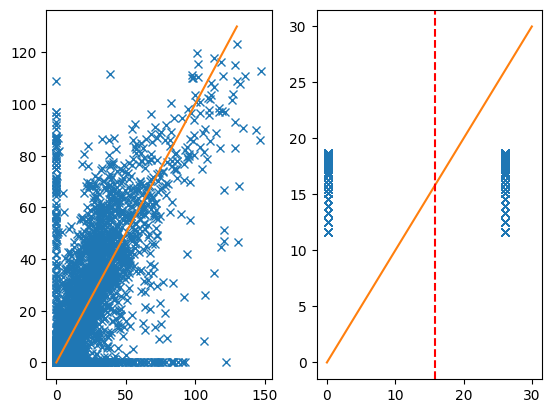

3744.732357327245
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.391E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.436E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.456E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.925  0.278E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.290  0.156E+00    32798   103.17  0.403   [Radiance 0.660 micron]
     6  -2.295  0.840E-01    35698   114.58  0.448   [Radiance 0.660 micron]
     7  -2.370  0.613E-01    39082   125.73  0.491   [Radiance 0.660 micron]
     8  -2.470  0.490E-01    42728   135.79  0.530   [Radiance 0.660 micron]
     9  -2.548  0.402E-01    47220   146.22  0.571   [Radiance 0.660 micron]
    10  -2.629  0.340E-01    52089   155.47  0.607   [Radiance 0.660 micron]
    11  -2.740  0.300E-01    56376   162.57  0.635   [Radiance 0.660 micron]
    12  -3.028  0.300E-01    56556   162.76  0.636   [Radianc

<Figure size 640x480 with 0 Axes>

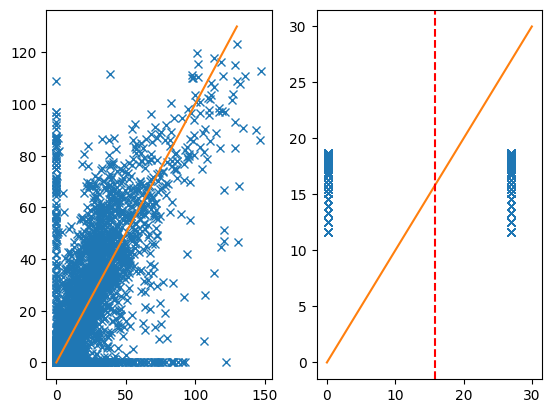

3769.1431038274673
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.391E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.289  0.435E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.455E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.925  0.278E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.290  0.156E+00    32798   103.17  0.403   [Radiance 0.660 micron]
     6  -2.296  0.839E-01    35684   114.54  0.447   [Radiance 0.660 micron]
     7  -2.370  0.612E-01    39066   125.68  0.491   [Radiance 0.660 micron]
     8  -2.468  0.490E-01    42706   135.73  0.530   [Radiance 0.660 micron]
     9  -2.551  0.403E-01    47139   146.03  0.570   [Radiance 0.660 micron]
    10  -2.629  0.339E-01    52083   155.46  0.607   [Radiance 0.660 micron]
    11  -2.742  0.300E-01    56310   162.46  0.635   [Radiance 0.660 micron]
    12  -3.030  0.300E-01    56491   162.65  0.635   [Radian

<Figure size 640x480 with 0 Axes>

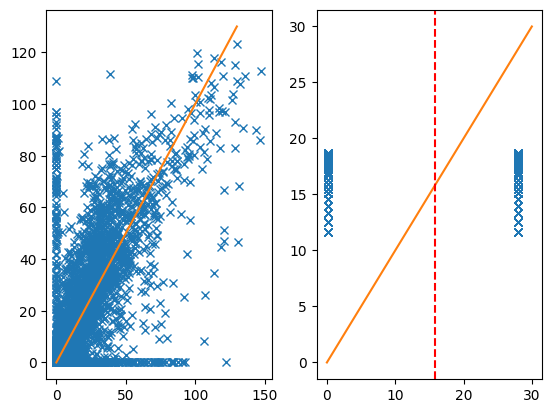

3798.676817608679
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.390E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.289  0.435E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.455E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.926  0.278E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.291  0.156E+00    32796   103.17  0.403   [Radiance 0.660 micron]
     6  -2.296  0.838E-01    35682   114.53  0.447   [Radiance 0.660 micron]
     7  -2.370  0.612E-01    39044   125.62  0.491   [Radiance 0.660 micron]
     8  -2.466  0.490E-01    42699   135.71  0.530   [Radiance 0.660 micron]
     9  -2.554  0.403E-01    47049   145.87  0.570   [Radiance 0.660 micron]
    10  -2.626  0.338E-01    52072   155.44  0.607   [Radiance 0.660 micron]
    11  -2.743  0.300E-01    56228   162.34  0.634   [Radiance 0.660 micron]
    12  -3.031  0.300E-01    56421   162.55  0.635   [Radianc

<Figure size 640x480 with 0 Axes>

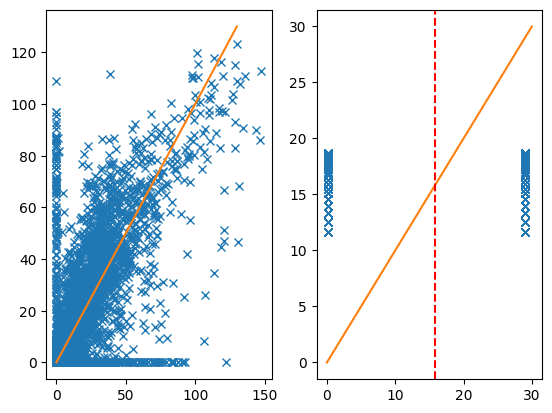

3836.0389037906843


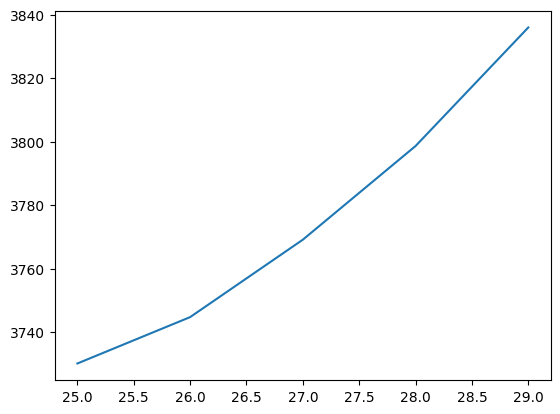

In [24]:
losses = []
for i in range(25, 30):
    solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers_reconstruct[0.66].medium['cloud'].reff.data * 0 + i
    initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers_reconstruct[0.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    loss = objective_function(x0)[0]
    plot(None)
    print(loss)
    losses.append(loss)
py.plot(range(25, 30), losses)